### Author: [Victor Melo](http://victormelo.me)

## Avançado

No NLTK (Natural Language Toolkit), uma plataforma para desenvolvimento de aplicações voltada para Processamento de Linguagem Natural para Python, estão disponíveis alguns __corpora__ com textos já classificados, __"taggeados"__, etc. Um deles, o corpus “Brown”, reune 500 textos de diferentes categorias.

O desafio consiste em:

1. Identificar as 2 categorias mais frequentes, extrair os textos pertencentes a cada uma dessas categorias;
2. Criar uma base de treino (66% do total dos textos) e uma base de teste (os 34% restantes); Os textos devem ser distribuídos aleatoriamente em ambas as bases;
3. Criar um classificador capaz de categorizar o conjuntos de teste.

O treinamento deve possuir duas etapas:

1. Pré-processamento:
 1. Extrair tokens, eliminando pontuações, stopwords e realizando stemming (ou stemização) nos termos restantes;
 2. Os textos de treinamento, representados por listas dos tokens restantes, devem ser convertidos em uma matriz TF-IDF (Text Frequency – Inverse Document Frequency). (Implementar a parte de IDF do algoritmo caso não encontre similar em outra biblioteca.)
2. Classificação:
 1. Cada linha da matriz, que representa um documento da base de treinamento, deve ser apresentada a um classificador juntamente com sua categoria, de forma que ocorra o aprendizado.	O teste do classificador deve seguir o mesmo raciocínio.

Sobre a entrega:

1. Deve-se escolher 3 diferentes classificadores que possuam hiperparâmetros para serem ajustados;
2. Para cada classificador, deve-se experimentar diferentes combinações dos valores dos seus hiperparâmetros e escolher o melhor ajuste para cada um;
3. Com os classificadores otimamente ajustados, deve-se treiná-los, testá-los e reportar os resultados, comparando-os e escolhendo o melhor, justificando a escolha. Deve-se também justificar as escolhas para os ajustes dos hiperparâmetros para cada classificador através de comparações;
4. Para as comparações, deve-se calcular uma matriz de confusão para cada classificador;
5. Evidentemente, outras métricas adicionais que, por ventura, sejam consideradas necessárias, podem ser utilizadas;
6. Os códigos e o relatório devem ser entregues em um ipython notebook, o qual deve ser auto-suficiente para ser executado (assumindo que o computador a executar possua todas as ferramentas necessárias instaladas).

Ferramentas sugeridas:
1. NLTK (pré-processamento – alguns dos passos estão implementados, outros não);
2. scikit-learn (classificação).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
import itertools
from nltk.corpus import brown
from nltk import SnowballStemmer
from nltk import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import expon as sp_expon
from sklearn.metrics import classification_report
import string

## Identificar as 2 categorias mais frequentes, extrair os textos pertencentes a cada uma dessas categorias;

In [2]:
dataset = {}
for category in brown.categories():
    fileids = []
    for fileid in brown.fileids(category):
        fileids.append(fileid)
    dataset[category] = fileids

two_most_frequent_classes = sorted(dataset.keys(), key=lambda x: len(dataset[x]), reverse=True)[:2]
print('two most frequent classes: ', 
      (two_most_frequent_classes[0], len(dataset[two_most_frequent_classes[0]])), 
      (two_most_frequent_classes[1], len(dataset[two_most_frequent_classes[1]])))

two most frequent classes:  ('learned', 80) ('belles_lettres', 75)


## Extrair tokens, eliminando pontuações, stopwords e realizando stemming (ou stemização) nos termos restantes;

In [3]:
def remove_punctuation(words):
    content = [w for w in words if w.isalpha()]
    return content

def remove_stopwords(words, lang='english'):
    s_words = stopwords.words(lang)
    content = [w for w in words if w.lower() not in s_words]
    return content

def stemming(words, stemming_type="SnowballStemmer", lang="english"):
    stemmers = ["PorterStemmer","SnowballStemmer","LancasterStemmer"]
    if stemming_type is False or stemming_type not in stemmers:
        return words
    else:
        l = []
        if stemming_type == "PorterStemmer":
            stemmer = PorterStemmer()
            for word in words:
                l.append(stemmer.stem(word))
        if stemming_type == "SnowballStemmer":
            stemmer = SnowballStemmer(lang)
            for word in words:
                l.append(stemmer.stem(word))
        if stemming_type == "LancasterStemmer":
            stemmer = LancasterStemmer()
            for word in words:
                l.append(stemmer.stem(word))
        return l

def preprocess_pipeline(words, lang='english', stemming_type='SnowballStemmer'):
    no_punctuation = remove_punctuation(words)
    no_stopwords = remove_stopwords(no_punctuation, lang=lang)
    stemmed = stemming(no_stopwords, lang=lang, stemming_type=stemming_type)
    return stemmed

#### Working example

In [4]:
words_example = brown.words(fileids=dataset[two_most_frequent_classes[0]][0])[:40]
words_preprocessed = preprocess_pipeline(words_example)

print ('Original words array: ', words_example, '\n')

print('Preprocessed words array: ', words_preprocessed)

Original words array:  ['1', '.', 'Introduction', 'It', 'has', 'recently', 'become', 'practical', 'to', 'use', 'the', 'radio', 'emission', 'of', 'the', 'moon', 'and', 'planets', 'as', 'a', 'new', 'source', 'of', 'information', 'about', 'these', 'bodies', 'and', 'their', 'atmospheres', '.', 'The', 'results', 'of', 'present', 'observations', 'of', 'the', 'thermal', 'radio'] 

Preprocessed words array:  ['introduct', 'recent', 'becom', 'practic', 'use', 'radio', 'emiss', 'moon', 'planet', 'new', 'sourc', 'inform', 'bodi', 'atmospher', 'result', 'present', 'observ', 'thermal', 'radio']


In [5]:
features = []
fileids = dataset[two_most_frequent_classes[0]] + dataset[two_most_frequent_classes[1]]
labels = np.append(
    np.repeat(two_most_frequent_classes[0], len(dataset[two_most_frequent_classes[0]])),
    np.repeat(two_most_frequent_classes[1], len(dataset[two_most_frequent_classes[1]])))

for fileid in fileids:
    words = brown.words(fileids=fileid)
    preprocessed = preprocess_pipeline(words)
    features.append(preprocessed)

## Criar uma base de treino (66% do total dos textos) e uma base de teste (os 34% restantes); Os textos devem ser distribuídos aleatoriamente em ambas as bases; 
## Os textos de treinamento, representados por listas dos tokens restantes, devem ser convertidos em uma matriz TF-IDF (Text Frequency – Inverse Document Frequency). (Implementar a parte de IDF do algoritmo caso não encontre similar em outra biblioteca.)


Eu setei um random_state = 42 para que os resultados que eu obtive possam ser reproduzidos.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.34, random_state=42)

X_train = [' '.join(text) for text in X_train] 
X_test = [' '.join(text) for text in X_test] 

print('Elementos treino: %d\nElementos teste: %d' % (len(X_train), len(X_test)))
vectorizer = TfidfVectorizer(max_df=0.5)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


Elementos treino: 102
Elementos teste: 53


Para evitar overfitting dos parâmetros (escolher os melhores hiperparâmetros apenas para resolver o conjunto de teste), decidi avaliar os diferentes hiperparâmetros dos modelos usando apenas o conjunto de treinamento (fazendo um 5-fold cross validation nesse conjunto). 

Reportarei o resultado final das melhores configurações dos modelos de classficação treinando com todo o conjunto de treinamento e testando com conjunto de teste separado anteriormente (esse conjunto não foi usado para selecionar os hiperparâmetros). 

Para selecionar os parâmetros usarei técnica estudada por [Bergstra e Bengio (2012)](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf), chamada de Random Search. Apesar de "inocente", é bastante efetiva para avaliar os hiperparâmetros e obter uma visão geral do desempenho do modelo. 

A distribuição que cada parâmetro seguira está determinada abaixo

In [10]:
svc_linear_param_dist = {'C': sp_expon(scale=1000), 
                         'kernel': ['linear']}

svc_rbf_param_dist = {'C': sp_expon(scale=1000), 
                      'gamma': sp_expon(scale=.1),
                      'kernel': ['rbf']}


knn_param_dist = {'n_neighbors': sp_randint(3, 50)}

rfc_param_dist = {"n_estimators": sp_randint(10, 100),
                "max_depth": sp_randint(1, 10),
                "max_features": sp_randint(1, 11),
                "min_samples_split": sp_randint(1, 11),
                "min_samples_leaf": sp_randint(1, 11),
                "bootstrap": [True, False],
                "criterion": ["gini", "entropy"]}


In [11]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)[:n_top]
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean test score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}\n".format(results['params'][candidate]))

def random_search(classifier, param_dist, n_iter=20, cv=5):
    clf = RandomizedSearchCV(classifier, 
                             param_dist, 
                             n_iter=n_iter,
                             cv=5)
    
    clf = clf.fit(X_train, y_train)
    report(clf.cv_results_)
    return clf

In [12]:
svc_rbf = random_search(SVC(), svc_rbf_param_dist, n_iter=30)

Model with rank: 1
Mean test score: 0.843 (std: 0.058)
Parameters: {'gamma': 0.23050615860323417, 'kernel': 'rbf', 'C': 1096.7877065086764}

Model with rank: 1
Mean test score: 0.843 (std: 0.058)
Parameters: {'gamma': 0.35634686978784913, 'kernel': 'rbf', 'C': 965.87370179517495}

Model with rank: 1
Mean test score: 0.843 (std: 0.058)
Parameters: {'gamma': 0.29591429145958265, 'kernel': 'rbf', 'C': 2872.8382538012438}



In [13]:
svc_linear = random_search(SVC(), svc_linear_param_dist, n_iter=30)

Model with rank: 1
Mean test score: 0.833 (std: 0.066)
Parameters: {'kernel': 'linear', 'C': 834.42777494793313}

Model with rank: 1
Mean test score: 0.833 (std: 0.066)
Parameters: {'kernel': 'linear', 'C': 1646.524729597965}

Model with rank: 1
Mean test score: 0.833 (std: 0.066)
Parameters: {'kernel': 'linear', 'C': 215.44891972196652}



In [14]:
knn = random_search(KNeighborsClassifier(), knn_param_dist, n_iter=15)

Model with rank: 1
Mean test score: 0.824 (std: 0.065)
Parameters: {'n_neighbors': 5}

Model with rank: 1
Mean test score: 0.824 (std: 0.065)
Parameters: {'n_neighbors': 11}

Model with rank: 3
Mean test score: 0.814 (std: 0.069)
Parameters: {'n_neighbors': 9}

Model with rank: 3
Mean test score: 0.814 (std: 0.071)
Parameters: {'n_neighbors': 13}

Model with rank: 3
Mean test score: 0.814 (std: 0.046)
Parameters: {'n_neighbors': 21}



In [15]:
rfc = random_search(RandomForestClassifier(), rfc_param_dist, n_iter=30)

Model with rank: 1
Mean test score: 0.843 (std: 0.055)
Parameters: {'max_features': 6, 'min_samples_split': 5, 'n_estimators': 34, 'max_depth': 9, 'bootstrap': False, 'min_samples_leaf': 4, 'criterion': 'gini'}

Model with rank: 2
Mean test score: 0.833 (std: 0.100)
Parameters: {'max_features': 10, 'min_samples_split': 6, 'n_estimators': 66, 'max_depth': 5, 'bootstrap': True, 'min_samples_leaf': 2, 'criterion': 'gini'}

Model with rank: 3
Mean test score: 0.824 (std: 0.069)
Parameters: {'max_features': 9, 'min_samples_split': 1, 'n_estimators': 76, 'max_depth': 9, 'bootstrap': False, 'min_samples_leaf': 4, 'criterion': 'gini'}

Model with rank: 3
Mean test score: 0.824 (std: 0.074)
Parameters: {'max_features': 8, 'min_samples_split': 1, 'n_estimators': 58, 'max_depth': 9, 'bootstrap': False, 'min_samples_leaf': 9, 'criterion': 'gini'}



## Para as comparações, deve-se calcular uma matriz de confusão para cada classificador;

Selecionei as configurações que possuem as melhores taxas em cada classificador (em caso de empate selecionei os que foram considerados primeiro) para testar com o conjunto que foi separado e fazer as comparações. Descartei a SVM Polinomial por apresentar resultados muito ruins.

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [22]:
def final_report(y_pred):
    
    print('\nAccuracy: %f\n' % metrics.accuracy_score(y_test, y_pred) )
    print(classification_report(y_test, y_pred))
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['belles_lettres', 'learned'],
                          title='Confusion matrix, without normalization')

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['belles_lettres', 'learned'], normalize=True,
                          title='Normalized confusion matrix')

    plt.show()


SVC RBF {'gamma': 0.23050615860323417, 'kernel': 'rbf', 'C': 1096.7877065086764}

Accuracy: 0.849057

                precision    recall  f1-score   support

belles_lettres       0.79      0.92      0.85        25
       learned       0.92      0.79      0.85        28

   avg / total       0.86      0.85      0.85        53



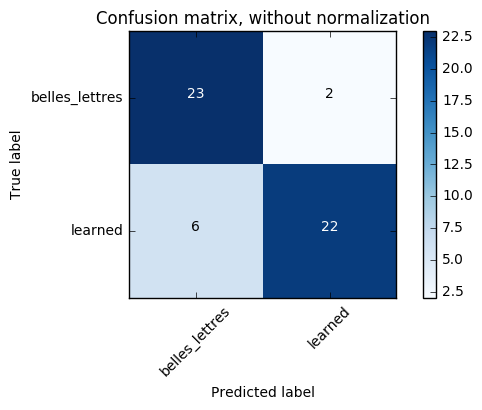

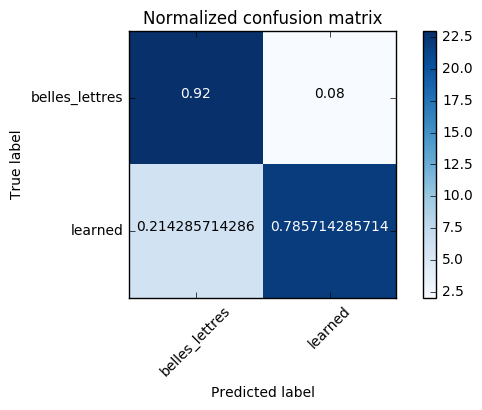

In [23]:
print('SVC RBF', svc_rbf.best_params_)
y_pred = SVC(**svc_rbf.best_params_).fit(X_train, y_train).predict(X_test)
final_report(y_pred)


SVC Linear {'kernel': 'linear', 'C': 834.42777494793313}

Accuracy: 0.830189

                precision    recall  f1-score   support

belles_lettres       0.77      0.92      0.84        25
       learned       0.91      0.75      0.82        28

   avg / total       0.84      0.83      0.83        53



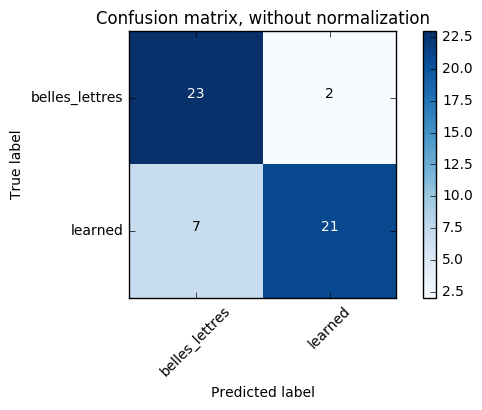

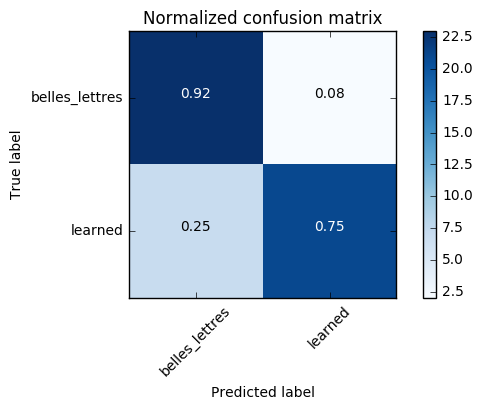

In [24]:
print('SVC Linear', svc_linear.best_params_)
y_pred = SVC(**svc_linear.best_params_).fit(X_train, y_train).predict(X_test)
final_report(y_pred)

kNN {'n_neighbors': 5}

Accuracy: 0.792453

                precision    recall  f1-score   support

belles_lettres       0.72      0.92      0.81        25
       learned       0.90      0.68      0.78        28

   avg / total       0.82      0.79      0.79        53



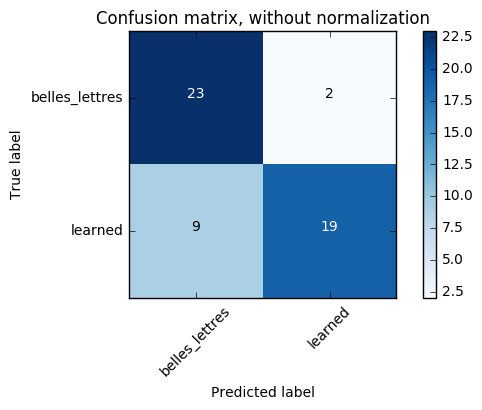

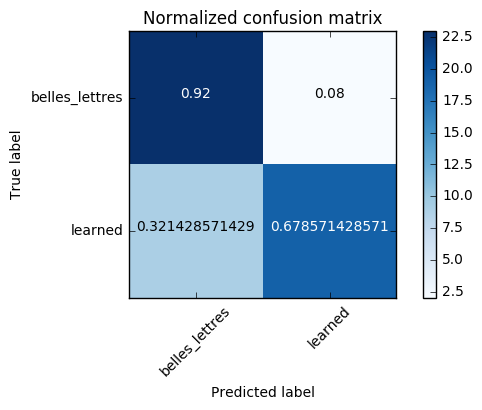

In [25]:
print('kNN', knn.best_params_)
y_pred = KNeighborsClassifier(**knn.best_params_).fit(X_train, y_train).predict(X_test)
final_report(y_pred)

RandomForest {'max_features': 6, 'min_samples_split': 5, 'n_estimators': 34, 'max_depth': 9, 'bootstrap': False, 'min_samples_leaf': 4, 'criterion': 'gini'}

Accuracy: 0.792453

                precision    recall  f1-score   support

belles_lettres       0.75      0.84      0.79        25
       learned       0.84      0.75      0.79        28

   avg / total       0.80      0.79      0.79        53



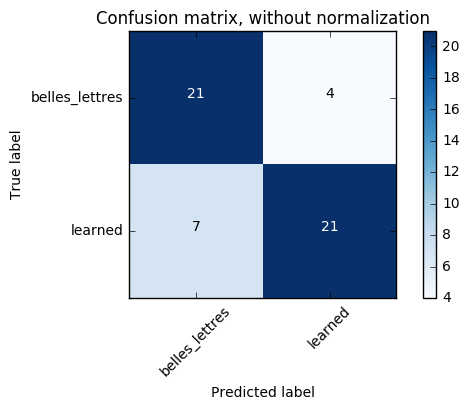

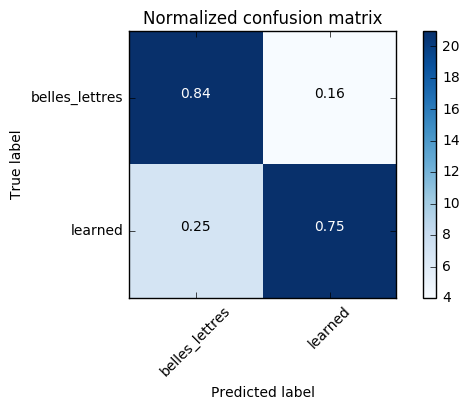

In [26]:
print('RandomForest', rfc.best_params_)
y_pred = RandomForestClassifier(**rfc.best_params_).fit(X_train, y_train).predict(X_test)
final_report(y_pred)

# Conclusão

Realizei a classificação com as duas classes mais frequentes do corpus disponível no NLTK "Brown", i.e. __belles_lettres__ e __learned__. As amostras foram divididas em dois conjuntos: treino (66% dos textos) e teste (34% dos textos), com um quantitivo absoluto de 102 e 53 textos, respectivamente.

Três classificadores foram experimentados, especificamente a SVM, k-nearest neighbors e a Random Forest.

Durante o pré-processamento dos tokens realizei as operações de eliminar pontuação, stopwords e um stemming foi aplicado. Essas operações estão implementadas nos métodos ```remove_punctuation```, ```remove_stopwords``` e ```stemming```, respectivamente.

Para converter a lista de tokens na matriz TF-IDF, utilizei a implementação própria da biblioteca sklearn na classe ```TfidfVectorizer```. Uma vez com esse vetor de características, os experimentos com os classificadores foram realizados.

Como citado anteriormente, para evitar overfitting dos parâmetros (me refiro a escolher os melhores hiperparâmetros que resolvem bem apenas o conjunto de teste), decidi avaliar os diferentes hiperparâmetros dos modelos usando apenas o conjunto de treinamento (fazendo um 5-fold cross validation nesse conjunto). 

O resultado final das melhores configurações dos modelos de classficação foi reportado treinando com todo o conjunto de treinamento e testando com conjunto de teste separado anteriormente (esse conjunto não foi usado para selecionar os hiperparâmetros). 

Para selecionar os parâmetros usei a técnica estudada por [Bergstra e Bengio (2012)](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf), chamada de Random Search. Apesar de "inocente", é bastante efetiva para avaliar os hiperparâmetros e obter uma visão geral do desempenho do modelo. 

O classificador que obteve o melhor resultado foi a SVM com o kernel RBF e com os parâmetros ```{'gamma': 0.23050615860323417, 'C': 1096.7877065086764}```. A taxa de acerto obtida por esse classificador foi 84.9057%. Logo em seguida a SVM Linear com o parâmetros {'C': 834.42777494793313} obteve uma taxa de acerto de 83%. Tanto o kNN quanto a RandomForest obtiveram uma taxa de classificação próximo de 79%.

Analisando a matriz de confusão, pode-se perceber que as SVMs (Linear e RBF) e a RandomForest classificaram erroneamente mais de 20% dos textos da classe learned como sendo da classe belles_lettres. Analisando as confusões da classe belles_lettres, apenas a RandomForest obteve um erro superior a 15% dessa classe, os outros classificadores classificaram 92% dos textos da classe corretamente. 

Uma das limitações desse estudo é a baixa quantidade de amostras na base. Dependendo dos elementos de treino e teste que sejam (aleatoriamente) separados, resultados diferentes podem ser obtidos. Procurei manter a os meus resultados reproduzíveis setando um random_state fixo (i.e. a separação é aleatória mas igual sempre) no método de separação de treino e teste.
